In [26]:
!pip install keras

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D


In [ ]:
from tensorflow.keras.optimizers import Adam # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

DATA Preprocessing

In [ ]:
data_dir_train=pathlib.Path(r"C:\Users\htslab\Desktop\21bps1128\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path(r"C:\Users\htslab\Desktop\21bps1128\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration\Test")
# C:\Users\htslab\Desktop\21bps1128\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration\Train

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [ ]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


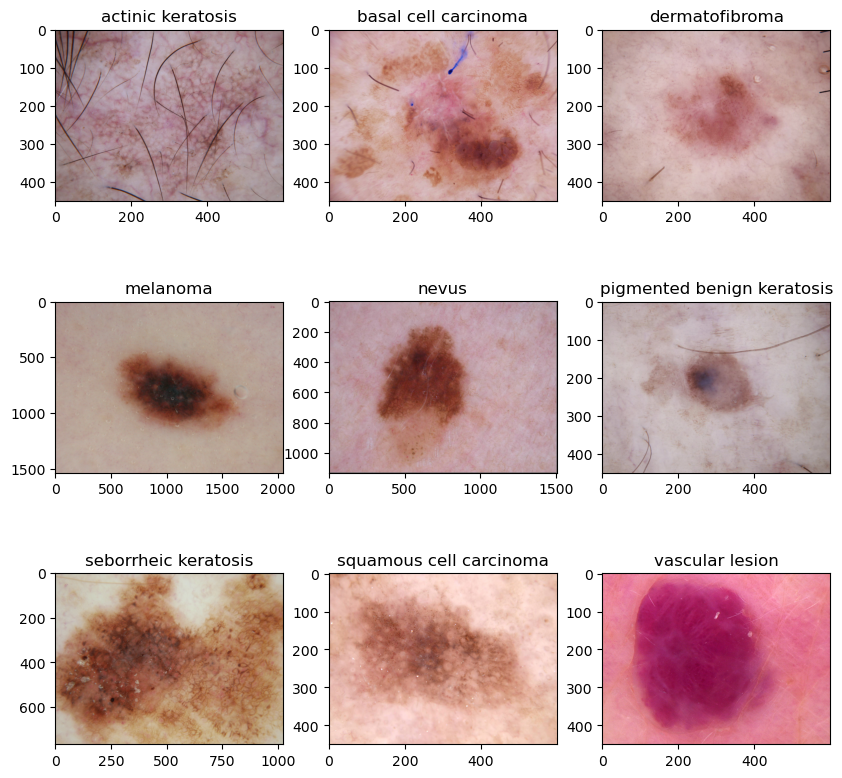

In [ ]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [22]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating CNN Layers

In [28]:
num_classes = 9
from keras.layers import Rescaling as ress
model = Sequential([ress \
                    (1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [30]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

# Define your optimizer
optimizer = Adam(learning_rate=0.001)

# Define your loss function
loss_function = SparseCategoricalCrossentropy()

# Compile your model with the correct arguments
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,686,025 (56.02 MB)

 Trainable params: 14,686,025 (56.02 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 527ms/step - accuracy: 0.2022 - loss: 2.1133 - val_accuracy: 0.1924 - val_loss: 2.0524
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 521ms/step - accuracy: 0.2396 - loss: 1.9739 - val_accuracy: 0.2103 - val_loss: 2.0677
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 509ms/step - accuracy: 0.2344 - loss: 2.0240 - val_accuracy: 0.2931 - val_loss: 1.9052
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 504ms/step - accuracy: 0.3181 - loss: 1.8062 - val_accuracy: 0.3311 - val_loss: 1.7758
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 501ms/step - accuracy: 0.3515 - loss: 1.7406 - val_accuracy: 0.4206 - val_loss: 1.6969
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 500ms/step - accuracy: 0.3875 - loss: 1.6607 - val_accuracy: 0.3423 - val_loss: 1.7548
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 501ms/step - accuracy: 0.3914 - loss: 1.6501 - val_accuracy: 0.4497 - val_loss: 1.5605
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 511ms/step - accuracy: 0.4437 - loss: 1.5487 - val_accu

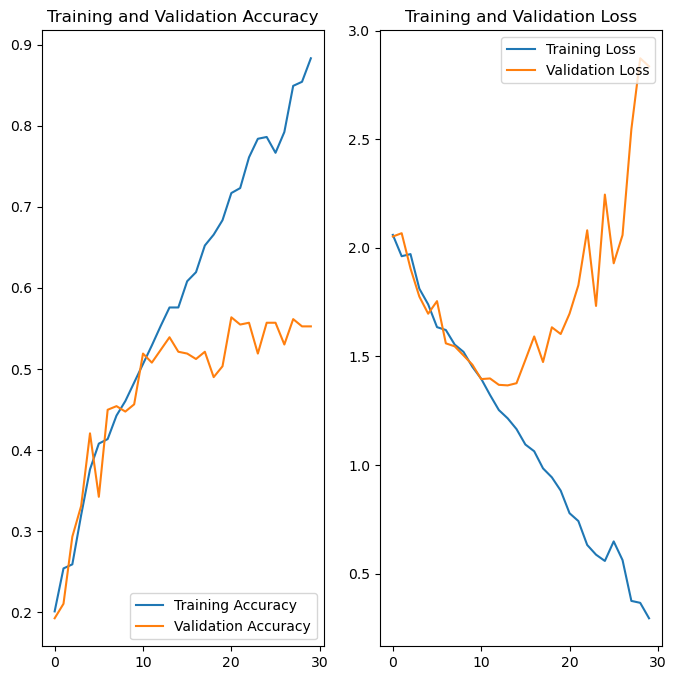

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model 2 : Data Augumentation with drop out layer.

In [36]:
from keras.layers import Rescaling as ress

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_augmentation = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

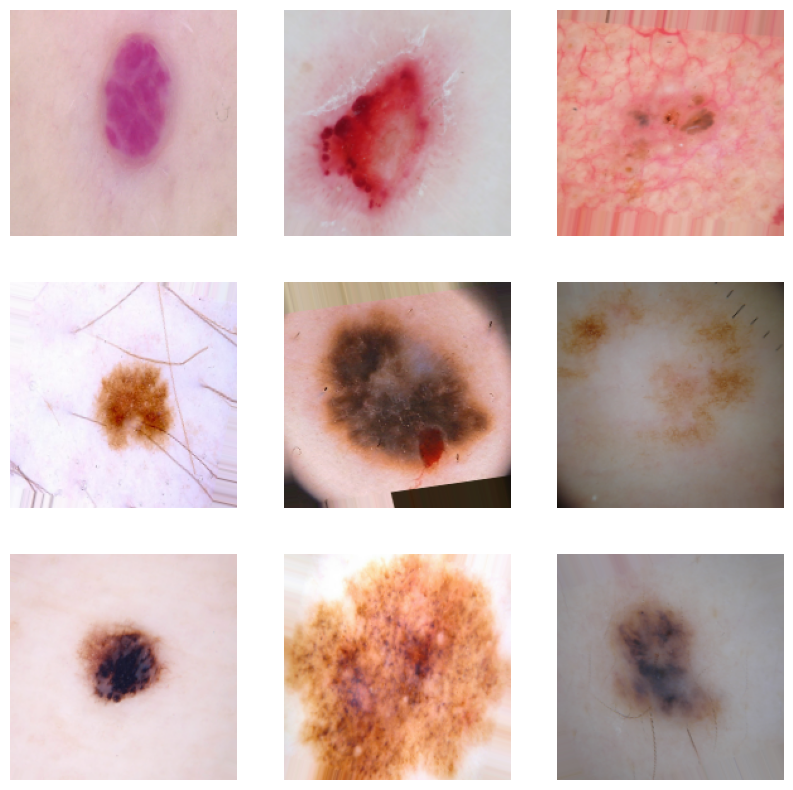

In [41]:
for images, _ in train_ds.take(1):
    augmented_images = data_augmentation.flow(images, batch_size=9)
    
    plt.figure(figsize=(10, 10))
    for i in range(9):
        augmented_image = next(augmented_images)[0].astype("uint8")
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image)
        plt.axis("off")
    
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

Augmentor : Class balance

In [14]:
import os
output_directory = os.getcwd() + '/augmented_images/'

In [15]:
# List all directories (classes) in the data directory
class_names = os.listdir(data_dir_train)

# Iterate through each class and count the number of images
for class_name in class_names:
    class_path = os.path.join(data_dir_train, class_name)
    if os.path.isdir(class_path):  # Check if it's a directory
        num_images = len(os.listdir(class_path))
        print(f'Class: {class_name}, Number of Images: {num_images}')

Class: actinic keratosis, Number of Images: 114
Class: basal cell carcinoma, Number of Images: 376
Class: dermatofibroma, Number of Images: 95
Class: melanoma, Number of Images: 438
Class: nevus, Number of Images: 357
Class: pigmented benign keratosis, Number of Images: 462
Class: seborrheic keratosis, Number of Images: 77
Class: squamous cell carcinoma, Number of Images: 181
Class: vascular lesion, Number of Images: 139


In [16]:
import Augmentor
import os
import pathlib

# Define the path to the training dataset
path_to_training_dataset = pathlib.Path(r'E:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration\Train')
output_directory = os.getcwd() + '/data/'

# Convert class_names to a list if it's not already
class_names = list(class_names)

# Iterate through each class and create Augmentor pipeline
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset / i), output_directory=str(output_directory + i + '/output/'))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CEC0F03730>: 100%|██████████| 500/500 [00:15<00:00, 32.75 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/basal cell carcinoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CEC0F986A0>: 100%|██████████| 500/500 [00:09<00:00, 51.66 Samples/s]


Initialised with 95 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/dermatofibroma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CEC10AE4A0>: 100%|██████████| 500/500 [00:14<00:00, 34.62 Samples/s] 


Initialised with 438 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/melanoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x542 at 0x1CEC0F4B760>: 100%|██████████| 500/500 [01:10<00:00,  7.11 Samples/s]  


Initialised with 357 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/nevus/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CEC0EB22F0>: 100%|██████████| 500/500 [01:05<00:00,  7.66 Samples/s]  


Initialised with 462 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/pigmented benign keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CEC0EC91B0>: 100%|██████████| 500/500 [00:14<00:00, 34.21 Samples/s] 


Initialised with 77 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1CEC3ECA920>: 100%|██████████| 500/500 [00:29<00:00, 16.77 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CEC3D3E650>: 100%|██████████| 500/500 [00:10<00:00, 48.87 Samples/s]                   


Initialised with 139 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CEC3E8FD90>: 100%|██████████| 500/500 [00:10<00:00, 47.22 Samples/s]                  


In [17]:
output_dir = pathlib.Path(output_directory)  # Convert output directory to a Path object
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

18000


total training image count = 18000 

-------------------------------------
Class name =  actinic keratosis
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  basal cell carcinoma
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  dermatofibroma
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  melanoma
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  nevus
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  pigmented benign keratosis
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  seborrheic keratosis
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  squamous cell carcinoma
count      =  2000
proportion =  0.1111111

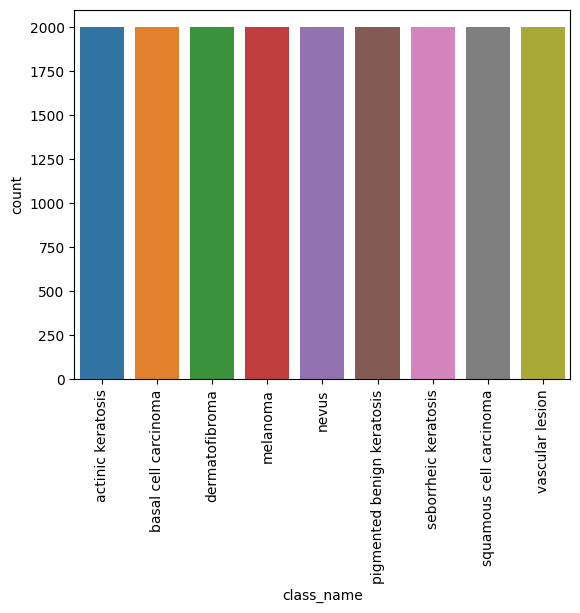

In [18]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])
temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

Model 3 : Model with Class balance data.

In [19]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18000 files belonging to 9 classes.
Using 14400 files for training.


In [20]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18000 files belonging to 9 classes.
Using 3600 files for validation.


In [21]:
print(train_ds.class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [32]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [33]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,loss = SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=25
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Model : Transefer learning Model

RESNET50


In [43]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

In [44]:
resnet_model = Sequential()

pretrained_model= keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(180,180,3),
    pooling='max',
    classes=9,
    classifier_activation="softmax",
)

for layer in pretrained_model.layers:
    layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(1024, activation='relu'))
resnet_model.add(Dense(9, activation='softmax'))

In [46]:
from tensorflow.keras import optimizers

# Compile the model
opt = optimizers.Adam(learning_rate=0.001)
resnet_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [47]:
history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 707ms/step - accuracy: 0.2885 - loss: 13.1568 - val_accuracy: 0.4497 - val_loss: 1.5594
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 673ms/step - accuracy: 0.5484 - loss: 1.2370 - val_accuracy: 0.5145 - val_loss: 1.4071
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 682ms/step - accuracy: 0.6592 - loss: 0.9528 - val_accuracy: 0.5481 - val_loss: 1.2981
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 37s 658ms/step - accuracy: 0.7258 - loss: 0.7544 - val_accuracy: 0.5570 - val_loss: 1.2532
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 691ms/step - accuracy: 0.7860 - loss: 0.5876 - val_accuracy: 0.5436 - val_loss: 1.3560
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 695ms/step - accuracy: 0.8286 - loss: 0.4895 - val_accuracy: 0.5459 - val_loss: 1.3416
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 37s 661ms/step - accuracy: 0.8691 - loss: 0.3931 - val_accuracy: 0.5951 - val_loss: 1.3373
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 37s 667ms/step - accuracy: 0.8702 - loss: 0.3805 - val_acc

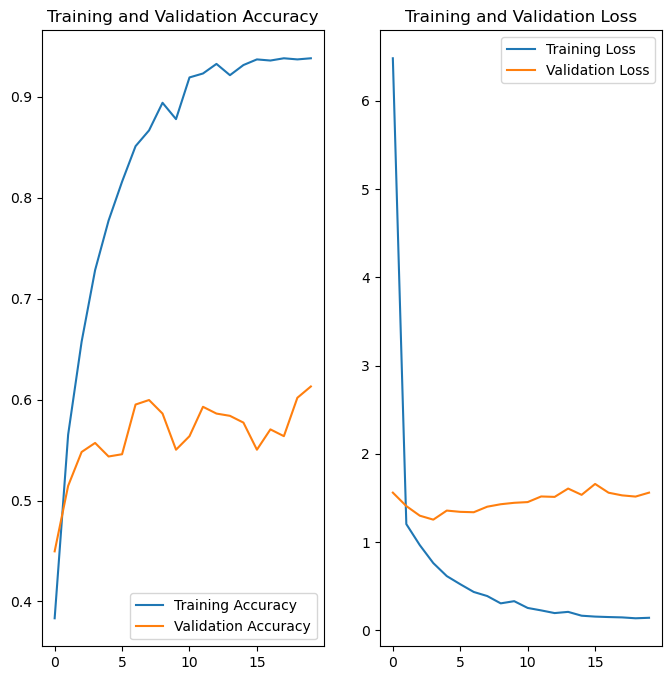

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load and preprocess the image
image_path = r'C:\Users\htslab\Desktop\21bps1128\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\ISIC_0000299.jpg'  # Replace with the path to your image
img = load_img(image_path, target_size=(180, 180))  # Adjust target_size based on your model's input shape
img = img_to_array(img)
img = np.expand_dims(img, axis=0)

# Make a prediction using the skin cancer classification model
prediction = resnet_model.predict(img)

# Debugging information
print("Shape of prediction array:", prediction.shape)
print("Prediction array:", prediction)

# Determine the class label based on the prediction
class_labels = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

# Check if the prediction shape matches the number of classes
if prediction.shape[-1] == len(class_labels):
    class_label = class_labels[np.argmax(prediction)]
    print(f"Predicted class: {class_label}")
else:
    print("Number of classes in prediction does not match the number of class labels.")

In [ ]:
import matplotlib.pyplot as plt

# Load the actual image
actual_img = load_img(image_path, target_size=(180, 180))  # Load the original image

# Plot the actual image
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(actual_img)
plt.title(f"Actual Image: {class_label}")
plt.axis('off')

# Plot the predicted image
plt.subplot(1, 2, 2)
plt.imshow(img[0].astype('uint8'))  # Convert to uint8 for imshow
plt.title(f"Predicted: {class_label}")
plt.axis('off')

# Show the plot
plt.show()

#### Inception V3

In [49]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

In [50]:
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add a global average pooling layer and a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(9, activation='softmax')(x)

In [51]:
Inception_model = Model(inputs=base_model.input, outputs=predictions)

In [54]:
from tensorflow.keras import optimizers

# Compile the model
opt = optimizers.Adam(learning_rate=0.001)
base_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [55]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [56]:
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [57]:
train_generator = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 2239 images belonging to 9 classes.


In [58]:
test_generator = validation_datagen.flow_from_directory(
    data_dir_test,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 118 images belonging to 9 classes.


In [63]:
Inception_model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [64]:
Inception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=20
)

Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 318s 4s/step - accuracy: 0.4097 - loss: 1.6603 - val_accuracy: 0.1667 - val_loss: 30.8753
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5625 - loss: 1.3490 - val_accuracy: 0.0000e+00 - val_loss: 24.3363
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 296s 4s/step - accuracy: 0.4785 - loss: 1.4660 - val_accuracy: 0.1458 - val_loss: 6.0928
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4375 - loss: 1.3337 - val_accuracy: 0.1364 - val_loss: 4.5129
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 290s 4s/step - accuracy: 0.4895 - loss: 1.4047 - val_accuracy: 0.3646 - val_loss: 3.4029
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6562 - loss: 1.0598 - val_accuracy: 0.1364 - val_loss: 3.3224
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 292s 4s/step - accuracy: 0.5433 - loss: 1.3015 - val_accuracy: 0.4167 - val_loss: 2.5629
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6562 - loss: 1.0753 - val_accuracy: 0.0909 

#### Hybrid Model (Inception V3 + DenseNet)

In [65]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, DenseNet121
from tensorflow.keras.layers import Concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [66]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, GlobalAveragePooling2D, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os

In [67]:
# Function to load and preprocess images
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    return img_array

In [68]:
# Load dataset from train and test folders
def load_dataset(train_dir, test_dir, num_samples=None):
    train_X = []
    train_y = []
    test_X = []
    test_y = []

    for class_name in os.listdir(train_dir):
        class_dir = os.path.join(train_dir, class_name)
        if os.path.isdir(class_dir):
            train_images = os.listdir(class_dir)
            for image_name in train_images[:num_samples]:
                image_path = os.path.join(class_dir, image_name)
                train_X.append(preprocess_image(image_path))
                train_y.append(class_name)

    for class_name in os.listdir(test_dir):
        class_dir = os.path.join(test_dir, class_name)
        if os.path.isdir(class_dir):
            test_images = os.listdir(class_dir)
            for image_name in test_images[:num_samples]:
                image_path = os.path.join(class_dir, image_name)
                test_X.append(preprocess_image(image_path))
                test_y.append(class_name)

    return np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y)


In [69]:
train_dir=pathlib.Path(r"C:\Users\htslab\Desktop\21bps1128\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
test_dir= pathlib.Path(r"C:\Users\htslab\Desktop\21bps1128\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration\Test")
# r"C:\Users\htslab\Desktop\21bps1128\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration\Train

In [70]:
X_train, y_train, X_test, y_test = load_dataset(train_dir, test_dir)

In [71]:
# Convert class labels to one-hot encoding
class_labels = np.unique(y_train)
label_map = {label: idx for idx, label in enumerate(class_labels)}
y_train = [label_map[label] for label in y_train]
y_test = [label_map[label] for label in y_test]
y_train = to_categorical(y_train, num_classes=len(class_labels))
y_test = to_categorical(y_test, num_classes=len(class_labels))

In [72]:
# Load InceptionV3 and DenseNet models
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [73]:
# Freeze layers in both models
for layer in inception_model.layers:
    layer.trainable = False

for layer in densenet_model.layers:
    layer.trainable = False

In [74]:
# Global average pooling layers
inception_gap = GlobalAveragePooling2D()(inception_model.output)
densenet_gap = GlobalAveragePooling2D()(densenet_model.output)

In [75]:
# Concatenate the output features from both models
concatenated_output = Concatenate()([inception_gap, densenet_gap])

In [76]:
# Additional dense layers for classification
output = Dense(512, activation='relu')(concatenated_output)
output = Dense(len(class_labels), activation='softmax')(output)

In [77]:
# Create concatenated model
concatenated_model = Model(inputs=[inception_model.input, densenet_model.input], outputs=output)

In [78]:
# Compile the model
concatenated_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [79]:
# Train the model
concatenated_model.fit([X_train, X_train], y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.3158 - loss: 2.5420 - val_accuracy: 0.0000e+00 - val_loss: 6.7353
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.5544 - loss: 1.2769 - val_accuracy: 0.0312 - val_loss: 7.8277
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.6683 - loss: 0.9980 - val_accuracy: 0.0045 - val_loss: 9.3772
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.7130 - loss: 0.8533 - val_accuracy: 0.0268 - val_loss: 9.4368
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.7242 - loss: 0.7698 - val_accuracy: 0.0714 - val_loss: 9.0554
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.7718 - loss: 0.6366 - val_accuracy: 0.0446 - val_loss: 10.0170
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.7933 - loss: 0.5741 - val_accuracy: 0.1116 - val_loss: 9.9702
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.8151 - loss: 0.5281 - val_accuracy: 0.0982 - va

With Callbacks

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint("concatenated_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)


In [ ]:
# Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

callback = [reduce_lr, early_stopping, checkpoint]

In [ ]:
# Train the model
history_concatenated=concatenated_model.fit([X_train, X_train], y_train, epochs=10, batch_size=32, validation_split=0.1, callbacks=callback)

In [ ]:
# Evaluate the model
y_pred = np.argmax(concatenated_model.predict([X_test, X_test]), axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print("Test Accuracy:", accuracy)

Detection

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [ ]:
# Load and preprocess the image
image_path = 'path_to_your_image.jpg'  # Replace with the path to your image
img = load_img(image_path, target_size=(img_height, img_width))  # Adjust target_size based on your model's input shape
img = img_to_array(img)
img = np.expand_dims(img, axis=0)

In [ ]:
prediction = combined_model.predict([img, img])

# Determine the class label based on the prediction
class_labels

# Check if the prediction shape matches the number of classes
if prediction.shape[-1] == len(class_labels):
    class_label = class_labels[np.argmax(prediction)]
    print(f"Predicted class: {class_label}")
else:
    print("Number of classes in prediction does not match the number of class labels.")


MobileNet

In [80]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

In [81]:
# Load MobileNetV2 model
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [82]:
# Freeze layers in the MobileNetV2 model
for layer in mobilenet_model.layers:
    layer.trainable = False

In [83]:
# Global average pooling layer
mobilenet_gap = GlobalAveragePooling2D()(mobilenet_model.output)

In [84]:
# Additional dense layers for classification
output = Dense(512, activation='relu')(mobilenet_gap)
output = Dense(len(class_labels), activation='softmax')(output)

# Create MobileNetV2 model
mobilenet_model_custom = Model(inputs=mobilenet_model.input, outputs=output)

In [85]:
# Compile the model
mobilenet_model_custom.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [87]:
# Train the model
mobilenet_model_custom.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 472ms/step - accuracy: 0.5381 - loss: 1.2880 - val_accuracy: 0.0625 - val_loss: 7.5057
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 383ms/step - accuracy: 0.6275 - loss: 1.0493 - val_accuracy: 0.0714 - val_loss: 8.0752
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 384ms/step - accuracy: 0.6863 - loss: 0.9184 - val_accuracy: 0.1339 - val_loss: 7.8001
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 376ms/step - accuracy: 0.7327 - loss: 0.7928 - val_accuracy: 0.0804 - val_loss: 8.6100
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 372ms/step - accuracy: 0.7610 - loss: 0.7145 - val_accuracy: 0.0670 - val_loss: 8.9450
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 373ms/step - accuracy: 0.8021 - loss: 0.6288 - val_accuracy: 0.1205 - val_loss: 8.5640
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.7968 - loss: 0.5719 - val_accuracy: 0.1652 - val_loss: 8.6686
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.7939 - loss: 0.5268 - val_accu

DenseNet121

In [88]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [89]:
# Load the pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

In [97]:
# Add a classification head to the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(9, activation='softmax')(x)

In [98]:
# Define the model
Dense_model = Model(inputs=base_model.input, outputs=predictions)

In [99]:
# Compile the model
Dense_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [93]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [100]:
batch_size = 32
epochs = 20

# Define the training and validation data generators
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    data_dir_test,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [102]:
# Train the model
Dense_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.6319 - loss: 1.0283 - val_accuracy: 0.3559 - val_loss: 2.0153
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6591 - loss: 0.9635 - val_accuracy: 0.3559 - val_loss: 1.9015
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.6745 - loss: 0.8941 - val_accuracy: 0.4492 - val_loss: 1.8364
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7113 - loss: 0.8226 - val_accuracy: 0.4407 - val_loss: 1.9008
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.6728 - loss: 0.8757 - val_accuracy: 0.4068 - val_loss: 2.0084
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6981 - loss: 0.7951 - val_accuracy: 0.4576 - val_loss: 2.0551
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7117 - loss: 0.7625 - val_accuracy: 0.4407 - val_loss: 2.3610
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7435 - loss: 0.7178 - val_accuracy: 0.4322 - val_loss:

Accuracy Measurements

In [103]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
# Get the true labels
true_labels = val_generator.classes

# Generate predictions
predictions = Dense_model.predict(val_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step 
Confusion Matrix:
[[0 6 1 2 2 5 0 0 0]
 [0 2 1 0 9 4 0 0 0]
 [0 2 0 2 2 4 0 3 3]
 [1 1 2 1 3 7 0 1 0]
 [0 3 0 2 5 5 0 0 1]
 [0 3 2 0 3 7 0 1 0]
 [0 1 0 0 1 1 0 0 0]
 [1 5 0 3 4 3 0 0 0]
 [0 1 0 0 1 1 0 0 0]]


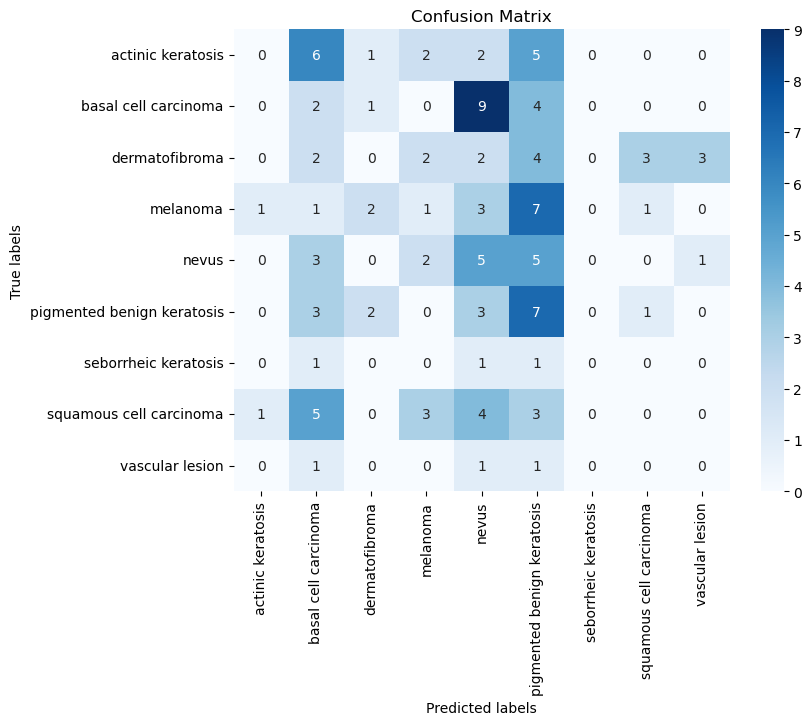

In [108]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=val_generator.class_indices, yticklabels=val_generator.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()